In [48]:
import scipy.optimize as sco
import scipy.stats as scs
import statsmodels.api as sm
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
symbols = ['AAPL','MSFT','AABA','DB','GLD']

fin_data = pd.DataFrame()
for sym in symbols:
    fin_data[sym] = data.DataReader(sym, data_source='yahoo', start='2014-09-12')['Adj Close']
fin_data.symbols = symbols

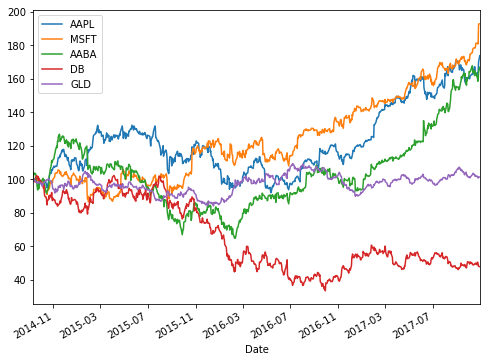

In [50]:
(fin_data/fin_data.iloc[0]*100.).plot(figsize=(8,6))

In [51]:
# calculate log of daily returns
rets = np.log(fin_data/fin_data.shift(1)).dropna()
rets.head()

,AAPL,MSFT,AABA,DB,GLD
Date,,,,,
2014-09-12,0.002265,-0.006403,0.038512,-0.006261,-0.009166
2014-09-15,-0.000295,-0.009899,-0.007726,-0.003145,0.002194
2014-09-16,-0.007605,0.011183,0.003753,0.001145,0.001600
2014-09-17,0.007113,-0.005146,-0.002814,0.002856,-0.010915
2014-09-18,0.002065,0.003434,-0.011809,0.020328,0.002040


In [52]:
rets.mean()*252

AAPL    0.176253
MSFT    0.209463
AABA    0.163380
DB     -0.235045
GLD     0.004402
dtype: float64

In [53]:
rets.cov()*252

,AAPL,MSFT,AABA,DB,GLD
AAPL,0.052852,0.026016,0.023143,0.023665,-0.003981
MSFT,0.026016,0.051155,0.026233,0.028386,-0.004354
AABA,0.023143,0.026233,0.079362,0.029466,-0.003870
DB,0.023665,0.028386,0.029466,0.154685,-0.013379
GLD,-0.003981,-0.004354,-0.003870,-0.013379,0.020613


In [100]:
# draw random asset allocation
noa = len(symbols)
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.1382516 ,  0.33599951,  0.00411094,  0.31335522,  0.20828273])

In [101]:
# expected return of portfolio
np.sum(rets.mean()*weights)*252

0.022682617919181403

In [102]:
# expected portfolio variance
np.dot(weights.T, np.dot(rets.cov() * 252,weights))

0.03089765419982806

In [103]:
# expected portfolio sqrt
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252,weights)))

0.17577728579036617

In [104]:
# simulate random allocations and calculate expected return vs. volatility
prets = []
pvols = []
for p in range(2500):
    # random weights
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean()*weights)*252)
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252,weights))))
prets = np.array(prets)
pvols = np.array(pvols)

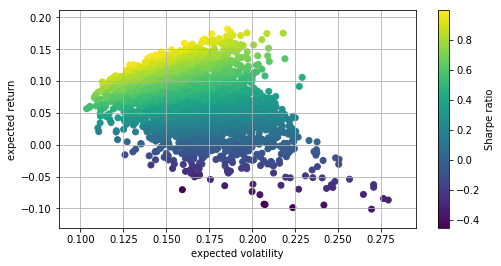

In [105]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio') # returns over risk

In [106]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret/pvol])

In [107]:
# we are looking to maximise the sharpe ratio (hence minimise the -ve)
def min_sharpe_function(weights):
    return -statistics(weights)[2]

In [108]:
# we have the constraint that the sum of the weights must equal 1
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [109]:
# each weight must be 0 <= w <= 1
bnds = tuple((0,1) for x in range(noa))

In [110]:
# this will be our starting point in weight space
noa * [1. / noa,]

[0.2, 0.2, 0.2, 0.2, 0.2]

In [111]:
# we our optimising the sharpe ratio in the weight space
#%%time
opts = sco.minimize(min_sharpe_function, noa * [1./noa,],method='SLSQP', bounds=bnds, constraints=cons)

In [112]:
opts

     fun: -1.018694699053698
     jac: array([  4.66257334e-05,  -1.31636858e-04,   2.29924917e-05,
         2.35364160e+00,   2.37211585e-04,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.25068353,  0.45795221,  0.09575559,  0.        ,  0.19560867])

In [113]:
opts['x'].round(3)

array([ 0.251,  0.458,  0.096,  0.   ,  0.196])

In [114]:
# get the expected return, vol and sharpe ratio
statistics(opts['x'].round(3))

array([ 0.15672067,  0.15384463,  1.01869448])

In [115]:
def min_variance_function(weights):
    return statistics(weights)[1]**2

In [116]:
optv = sco.minimize(min_variance_function, noa * [1./noa,],method='SLSQP', bounds=bnds, constraints=cons)

In [117]:
optv

     fun: 0.010562483487021096
     jac: array([ 0.02116739,  0.02118942,  0.02124927,  0.02128087,  0.02107383,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 84
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([ 0.12805224,  0.12618003,  0.0596677 ,  0.06812439,  0.61797564])

In [118]:
optv['x'].round(3)

array([ 0.128,  0.126,  0.06 ,  0.068,  0.618])

In [119]:
statistics(optv['x'].round(3))

array([ 0.04549267,  0.10277402,  0.44264762])

In [120]:
def min_port_function(weights):
    return statistics(weights)[1]

In [121]:
trets = np.linspace(0.0,0.25,50)
tvols = []
for tret in trets:
    # constrainsts are
    # 1 - the return is fixed
    # 2 - the weights sum to 1 as before... ditto bounds 0<=w<-1
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0]-tret},
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0,1) for x in range(noa))
    opts = sco.minimize(min_port_function, noa * [1./noa,],method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(opts['fun'])
tvols = np.array(tvols)

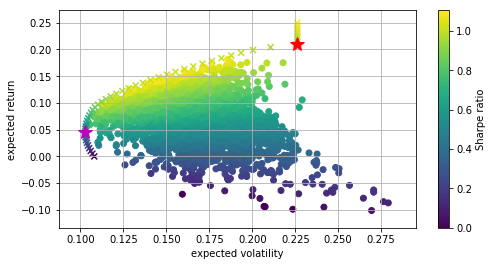

In [127]:
plt.figure(figsize=(8,4))
# random portfolio composition
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
# efficient frontier
plt.scatter(tvols, trets, c=trets/tvols, marker='x')
# portfolio with highest Sharpe ratio
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize=15.0)
# minimum variance portfolio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'm*', markersize=15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')